In [ ]:
# If using GG Colab, you need to upload file kaggle.json
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import random
import time
import os
import kaggle

# Import Dataset

*https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge*

In [4]:
dataset_url = 'kumaresanmanickavelu/lyft-udacity-challenge'
download_path = './road_dataset'

if os.path.isdir(download_path) and any(os.scandir(download_path)):
    print(f'Dataset already exists in {download_path}')
else:
    print(f'Downloading dataset from Kaggle: {dataset_url}')
    kaggle.api.dataset_download_files(dataset_url, path=download_path, unzip=True)
    print(f'Dataset downloaded and extracted to {download_path}')

Dataset already exists in ./road_dataset


In [5]:
def display_images(data_folder, num_to_display, shuffle=False):
    if num_to_display < 2 or num_to_display % 2 != 0:
        raise ValueError("num_to_display must be an even number and at least 2.")

    image_paths = glob.glob(f'./road_dataset/{data_folder}/{data_folder}/CameraRGB/*.png')  # returns list of file path
    mask_paths =  glob.glob(f'./road_dataset/{data_folder}/{data_folder}/CameraSeg/*.png')

    # Pick randomly images
    if shuffle:
        indices = random.sample(range(len(image_paths)), num_to_display)
        image_paths = [image_paths[i] for i in indices]
        mask_paths = [mask_paths[i] for i in indices]
    else:
        image_paths = image_paths[:num_to_display]
        mask_paths = mask_paths[:num_to_display]

    # Convert images to arrays
    image_arrs = [None] * num_to_display
    mask_arrs = [None] * num_to_display
    for i in range(num_to_display):
        image_arrs[i] = cv2.imread(image_paths[i])
        mask_arrs[i] = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # if not IMREAD_GRAYSCALE, images will be black

    # Visualize a pair of 2 images, 2 masks in each row
    fig, axes = plt.subplots(num_to_display//2, 4, figsize=(12, 12))
    axes = axes.flatten()
    for i in range(num_to_display):
        axes[2*i].imshow(image_arrs[i])
        axes[2*i + 1].imshow(mask_arrs[i], cmap='gray')
        axes[2*i].axis('off')
        axes[2*i + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
data_folders = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']

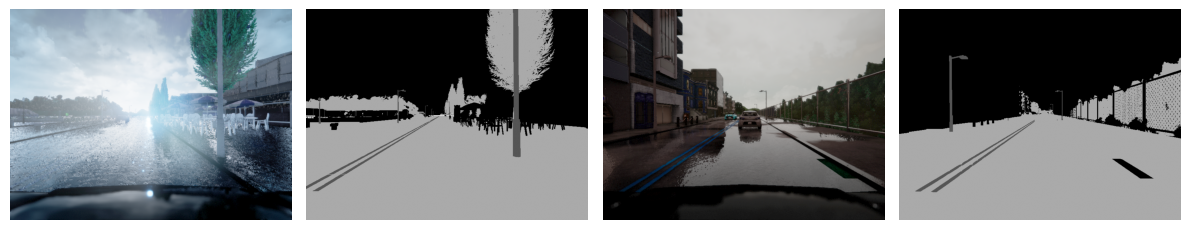

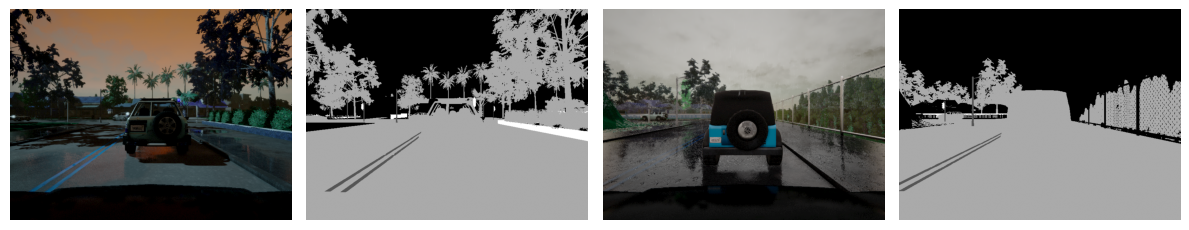

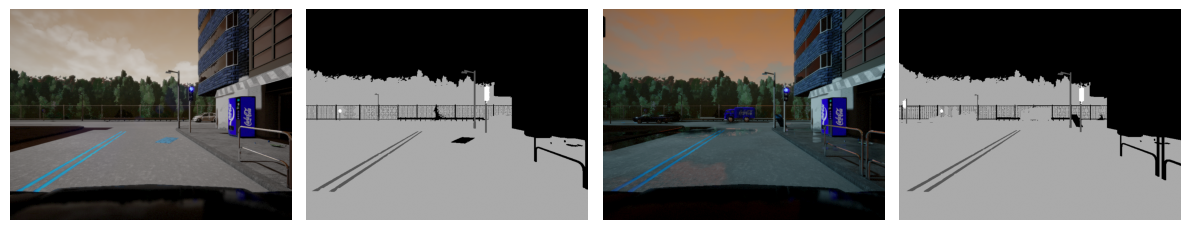

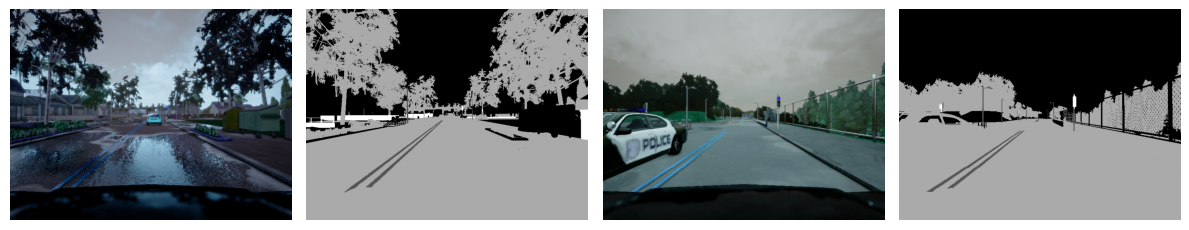

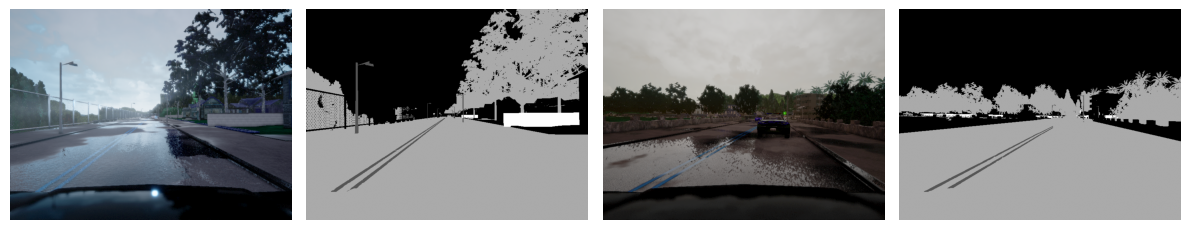

In [7]:
for i in range(len(data_folders)):
    display_images(data_folders[i], 2, shuffle=True)

# Data Preprocessing

In [8]:
image_paths = []
mask_paths = []

for folder in data_folders:
    images_each_folder = glob.glob(f'./road_dataset/{folder}/{folder}/CameraRGB/*.png')
    masks_each_folder = glob.glob(f'./road_dataset/{folder}/{folder}/CameraSeg/*.png')
    image_paths.extend(images_each_folder)
    mask_paths.extend(masks_each_folder)

len(image_paths), len(mask_paths)

(5000, 5000)

In [9]:
image_paths = tf.constant(image_paths)  # converts list to tensor
mask_paths = tf.constant(mask_paths)

image_paths

<tf.Tensor: shape=(5000,), dtype=string, numpy=
array([b'./road_dataset/dataA/dataA/CameraRGB/09_00_210.png',
       b'./road_dataset/dataA/dataA/CameraRGB/07_00_050.png',
       b'./road_dataset/dataA/dataA/CameraRGB/03_01_100.png', ...,
       b'./road_dataset/dataE/dataE/CameraRGB/02_02_019.png',
       b'./road_dataset/dataE/dataE/CameraRGB/03_00_078.png',
       b'./road_dataset/dataE/dataE/CameraRGB/02_01_099.png'],
      dtype=object)>

In [10]:
path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
path_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [11]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)  # tensor of raw byte content, cannot read
    image = tf.image.decode_png(image, channels=3)  # decode to the tensor of shape (height, width, channels)
    image = tf.image.convert_image_dtype(image, tf.float32) # normalize from 0 to 1

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # reduce from 3 channels to 1
    # no normalization on a mask because it contains each class for each pixel
    return image, mask

In [12]:
# (192, 256) or (96, 128)
def resize_image(image, mask):
    resized_image = tf.image.resize(image, (96, 128), method='nearest')
    resized_mask = tf.image.resize(mask, (96, 128), method='nearest')  # pick this method to preserve classes
    return resized_image, resized_mask

In [13]:
image_dataset = path_dataset.map(process_path)
image_dataset  # None in the shape indicates a dimension that is flexible or variable in size

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>

In [14]:
image_dataset = image_dataset.map(resize_image)
image_dataset

<_MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>

In [15]:
# If you want to know the number of classes
n_classes = set()

for _, mask_tensor in image_dataset.take(1000):
    mask_array = mask_tensor.numpy()
    unique_values = np.unique(mask_array.flatten())
    n_classes.update(unique_values)

n_classes = sorted(n_classes)
n_classes

[np.uint8(0),
 np.uint8(1),
 np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8),
 np.uint8(9),
 np.uint8(10),
 np.uint8(11),
 np.uint8(12)]

# Building Model based on U-NetV2

### Encoder

In [16]:
def downsampling_block(input, n_filters, dropout_prob=0, max_pooling=True):
    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same',
        activation='relu',
        kernel_initializer='he_normal')(input)

    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same',
        activation='relu',
        kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = keras.layers.Dropout(dropout_prob)(conv)

    residual = conv

    if max_pooling:
        pool = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv)
        return pool, residual

    return conv, residual

### Decoder

In [17]:
def upsampling_block(input, residual, n_filters):
    up_conv = keras.layers.Conv2DTranspose(n_filters, kernel_size=(3,3), strides=(2,2), padding='same')(input)
    concat = keras.layers.Concatenate(axis=3)([up_conv, residual])

    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same',
        activation='relu',
        kernel_initializer='he_normal')(concat)

    conv = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same',
        activation='relu',
        kernel_initializer='he_normal')(conv)

    return conv

### A Complete Model

In [18]:
def UNet(input_shape, n_filters, n_classes):
    input = keras.layers.Input(shape=input_shape)  # input_shape(H, W, 3)

    pool_1, res_1 = downsampling_block(input, n_filters)  # (H/2, W/2, C), (H, W, C)
    pool_2, res_2 = downsampling_block(pool_1, n_filters*2)  # (H/4, W/4, 2C), (H/2, W/2, 2C)
    pool_3, res_3 = downsampling_block(pool_2, n_filters*4)  # (H/8, W/8, 4C), (H/4, W/4, 4C)
    pool_4, res_4 = downsampling_block(pool_3, n_filters*8, dropout_prob=0.3)  # (H/16, W/16, 8C), (H/8, W/8, 8C)

    conv_5, _ = downsampling_block(pool_4, n_filters*16, dropout_prob=0.3, max_pooling=False)  # (H/16, W/16, 16C)

    conv_6 = upsampling_block(conv_5, res_4, n_filters*8)  # (H/8, W/8, 8C)
    conv_7 = upsampling_block(conv_6, res_3, n_filters*4)  # (H/4, W/4, 4C)
    conv_8 = upsampling_block(conv_7, res_2, n_filters*2)  # (H/2, W/2, 2C)
    conv_9 = upsampling_block(conv_8, res_1, n_filters)  # (H, W, C)

    conv_10 = keras.layers.Conv2D(
        n_filters, kernel_size=(3,3), strides=(1,1), padding='same',
        activation='relu',
        kernel_initializer='he_normal')(conv_9)  # (H, W, C)

    output = keras.layers.Conv2D(n_classes, kernel_size=(1,1), strides=(1,1), padding='same')(conv_10)  # (H, W, n_classes)

    model = keras.models.Model(inputs=input, outputs=output)
    return model

In [19]:
image_dataset.element_spec

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))

In [20]:
INPUT_SHAPE = image_dataset.element_spec[0].shape
N_FILTERS = 32
N_CLASSES = len(n_classes)

unet = UNet(INPUT_SHAPE, N_FILTERS, N_CLASSES)
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 128, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 96, 128, 32)    │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 96, 128, 32)    │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 48, 64, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 48, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 64, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 24, 32, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 24, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 24, 32, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 12, 16, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 12, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 12, 16, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 12, 16, 256)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 8, 256)      │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 6, 8, 512)      │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 6, 8, 512)      │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 6, 8, 512)      │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 8,640,141 (32.96 MB)

 Trainable params: 8,640,141 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [21]:
unet.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
BUFFER_SIZE = 500
N_SAMPLES = len(image_paths)
TRAIN_SIZE = int(0.8 * N_SAMPLES)
BATCH_SIZE = 64

shuffled_dataset = image_dataset.shuffle(buffer_size=N_SAMPLES)
shuffled_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>

In [23]:
train_dataset = shuffled_dataset.take(TRAIN_SIZE)
val_dataset = shuffled_dataset.skip(TRAIN_SIZE)

train_dataset, val_dataset

(<_TakeDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>)

In [24]:
train_dataset = train_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.uint8, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.uint8, name=None))>)

In [25]:
EPOCHS = 50

callbacks=[
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint("unet.keras", monitor='val_loss', save_best_only=True, verbose=0)
]


history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.4274 - loss: 1.7891 - val_accuracy: 0.7479 - val_loss: 0.7495 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.7805 - loss: 0.6429 - val_accuracy: 0.8605 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.8521 - loss: 0.4629 - val_accuracy: 0.8655 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.8897 - loss: 0.3559 - val_accuracy: 0.9076 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.9135 - loss: 0.2758 - val_accuracy: 0.9250 - val_loss: 0.2376 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.9257 - loss: 0.2343 - val_accuracy: 0.9332 - val_loss: 0.2089 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.9340 - loss: 0.20

# Visulize Predictions

In [26]:
val_images = val_dataset.map(lambda x, y: x)
val_images

<_MapDataset element_spec=TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None)>

In [27]:
preds = unet.predict(val_images)
preds.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step


(1000, 96, 128, 13)

In [28]:
preds[0, 0, 0]

array([ 8.179768  ,  2.0811815 ,  0.11773592, -1.3468817 , -0.7023296 ,
       -0.65311635, -6.9477863 , -2.2855077 , -6.159217  ,  2.162494  ,
       -2.1858366 , -6.9180627 , -1.6060588 ], dtype=float32)

In [29]:
pred_masks = tf.math.argmax(preds, axis=-1)  # returns index of max value'channel with tensor of shape (n_samples, height, width)
pred_masks = pred_masks[..., tf.newaxis]  # add a new axis at the end
pred_masks.shape

TensorShape([1000, 96, 128, 1])

In [30]:
pred_masks[0, 0, 0]  # idx of max value from preds = 0

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [31]:
val_images = []  # list containing batches of tensor
true_masks = []

for batch_x, batch_y in val_dataset:  # take each batch of BATCH_SIZE samples
    val_images.append(batch_x)  # batch_X.shape (BATCH_SIZE, H, W, C)
    true_masks.append(batch_y)  # batch_Y.shape (BATCH_SIZE, H, W, 1)

val_images = tf.concat(val_images, axis=0)  # concat batches of tensor into 1 batch
true_masks = tf.concat(true_masks, axis=0)

val_images.shape, true_masks.shape

(TensorShape([1000, 96, 128, 3]), TensorShape([1000, 96, 128, 1]))

In [32]:
def display_predictions(num_to_display, random=False):
  n_images = len(val_images)
  num_to_display = min(num_to_display, n_images)

  if random:
    indices = np.random.choice(n_images, num_to_display, replace=False)
  else:
    indices = range(num_to_display)

  fig, axes = plt.subplots(nrows=num_to_display, ncols=3, figsize=(12, 12*3))
  axes = axes.flatten()

  for i in range(num_to_display):
      idx = indices[i]

      axes[3*i].imshow(keras.preprocessing.image.array_to_img(val_images[idx]))
      axes[3*i].set_title(f"Validation Image {idx}")
      axes[3*i].axis('off')

      axes[3*i + 1].imshow(keras.preprocessing.image.array_to_img(true_masks[idx]))
      axes[3*i + 1].set_title(f"True Mask {idx}")
      axes[3*i + 1].axis('off')

      axes[3*i + 2].imshow(keras.preprocessing.image.array_to_img(pred_masks[idx]))
      axes[3*i + 2].set_title(f"Predicted Mask {idx}")
      axes[3*i + 2].axis('off')

  plt.tight_layout()
  plt.show()

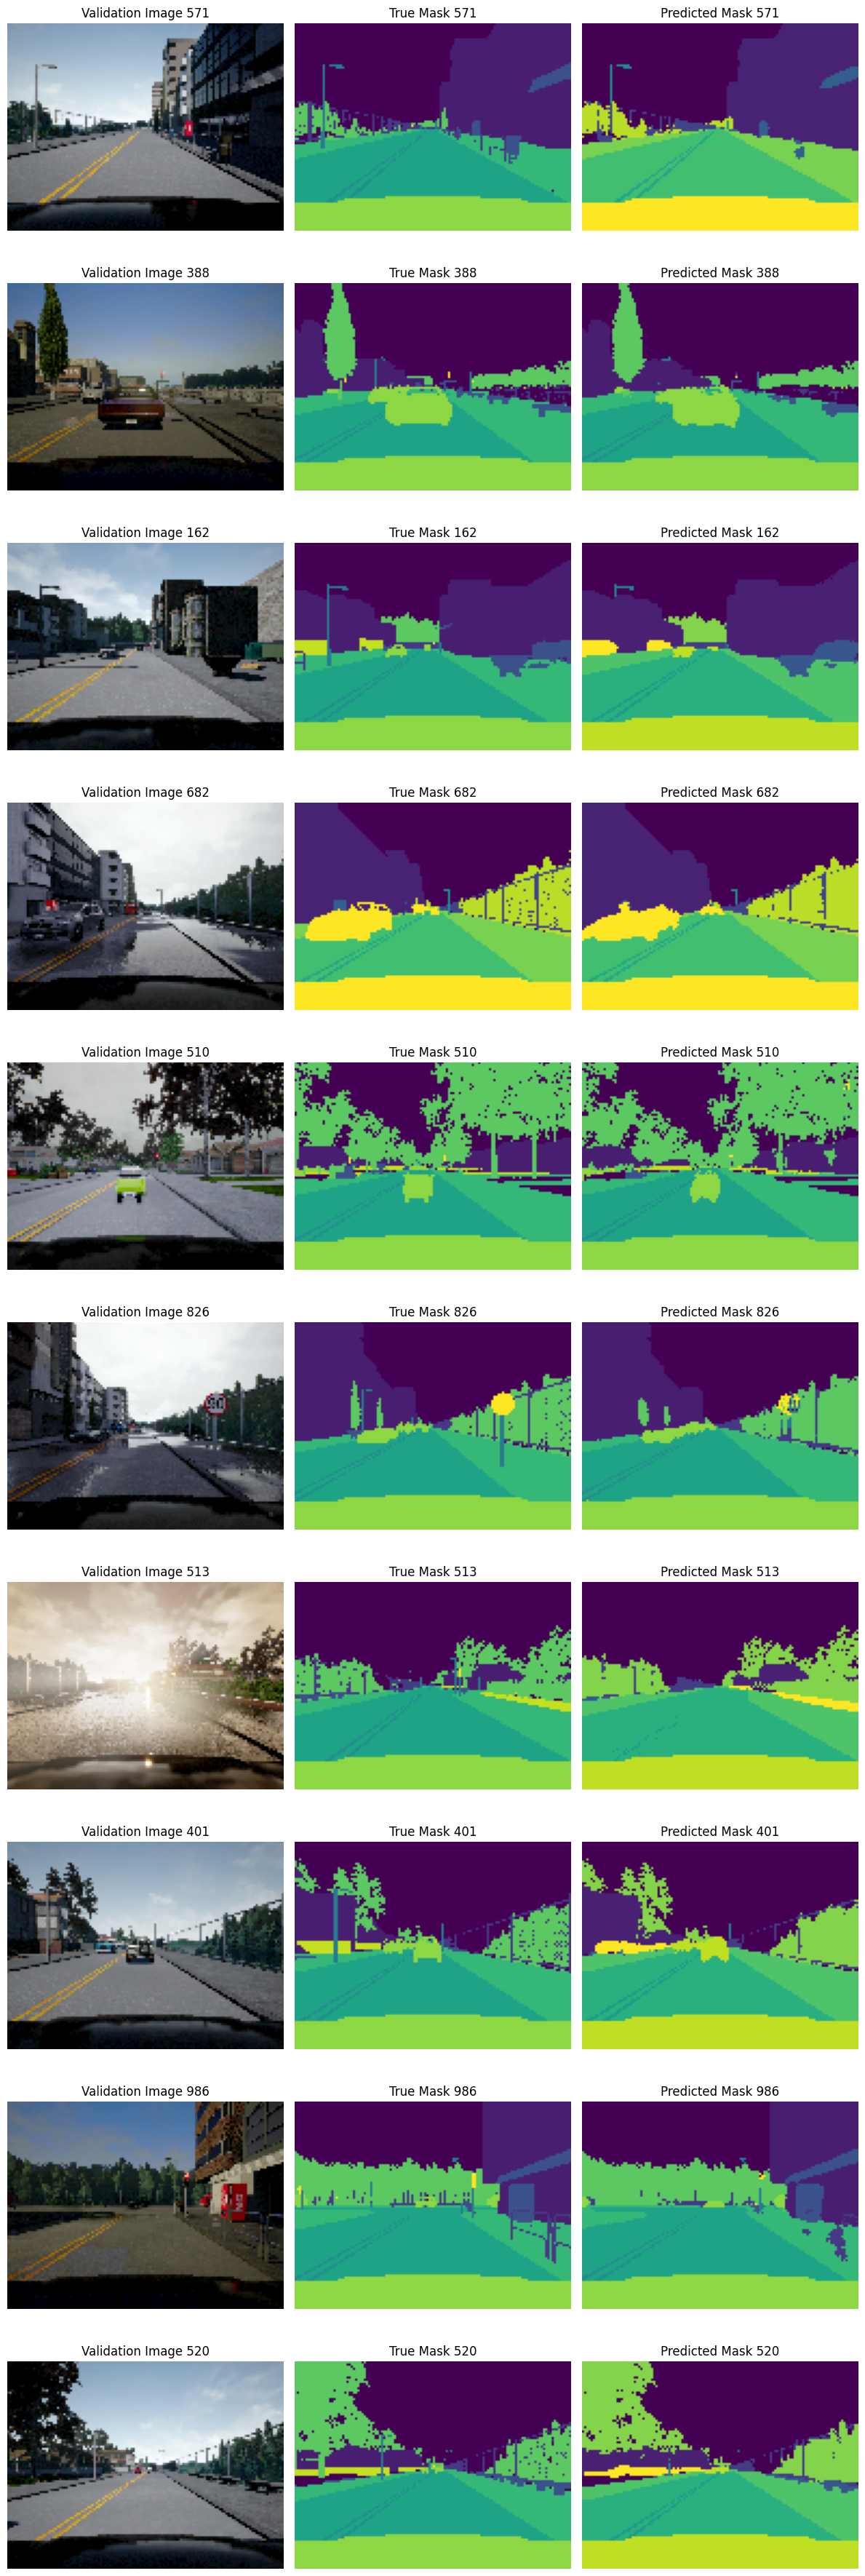

In [33]:
display_predictions(10, random=True)

# Evaluate Model

In [34]:
def iou(y_true, y_pred, n_classes, smooth=1e-7):
    """
    Computes Intersection over Union (IoU) for multi-class segmentation using TensorFlow.

    Args:
        y_true: Tensor of shape (n_samples, height, width, 1) - Ground truth class labels
        y_pred: Tensor of shape (n_samples, height, width, 1) - Predicted class labels
        n_classes: Number of segmentation classes
        smooth: Smoothing factor to avoid division by zero (default: 1e-7)

    Returns:
        Mean IoU over batch samples and classes if present (Tensor)
    """

    y_true = tf.squeeze(y_true, axis=-1)  # Shape: (batch_size, height, width)
    y_pred = tf.squeeze(y_pred, axis=-1)

    iou_per_class = []

    for c in range(n_classes):
        y_true_c = tf.equal(y_true, c)  # Binary mask for class c
        y_pred_c = tf.equal(y_pred, c)

        intersection = tf.reduce_sum(tf.cast(tf.logical_and(y_true_c, y_pred_c), tf.float32), axis=[1, 2])  # Shape: (batch_size,)
        union = tf.reduce_sum(tf.cast(tf.logical_or(y_true_c, y_pred_c), tf.float32), axis=[1, 2])

        iou = tf.where(union > 0, (intersection + smooth) / (union + smooth), tf.constant(np.nan, dtype=tf.float32))
        iou_per_class.append(iou)

    iou_per_class = tf.stack(iou_per_class, axis=1)  # Shape: (batch_size, n_classes)

    valid_iou = tf.boolean_mask(iou_per_class, tf.logical_not(tf.math.is_nan(iou_per_class)))  # Ignore NaN

    miou = tf.reduce_mean(valid_iou)
    return miou

In [35]:
def dice_coef(y_true, y_pred, n_classes, smooth=1e-7):
    """
    Computes the Dice Coefficient for multi-class segmentation using TensorFlow.

    Args:
        y_true: Tensor of shape (n_samples, height, width, 1) - Ground truth class labels
        y_pred: Tensor of shape (n_samples, height, width, 1) - Predicted class labels
        n_classes: Number of segmentation classes
        smooth: Smoothing factor to avoid division by zero (default: 1e-7)

    Returns:
        Mean Dice Coefficient over batch samples and classes if present (Tensor)
    """

    y_true = tf.squeeze(y_true, axis=-1)  # Shape: (batch_size, height, width)
    y_pred = tf.squeeze(y_pred, axis=-1)

    dice_per_class = []

    for c in range(n_classes):
        y_true_c = tf.equal(y_true, c)  # Binary mask for class c
        y_pred_c = tf.equal(y_pred, c)

        intersection = tf.reduce_sum(tf.cast(tf.logical_and(y_true_c, y_pred_c), tf.float32), axis=[1, 2])  # Shape: (batch_size,)
        total_true = tf.reduce_sum(tf.cast(y_true_c, tf.float32), axis=[1, 2])  # Total pixels in ground truth
        total_pred = tf.reduce_sum(tf.cast(y_pred_c, tf.float32), axis=[1, 2])  # Total pixels in prediction

        dice = (2.0 * intersection + smooth) / (total_true + total_pred + smooth)
        dice_per_class.append(dice)

    dice_per_class = tf.stack(dice_per_class, axis=1)  # Shape: (batch_size, n_classes)

    valid_dice = tf.boolean_mask(dice_per_class, tf.logical_not(tf.math.is_nan(dice_per_class)))

    mean_dice = tf.reduce_mean(valid_dice)
    return mean_dice

In [36]:
iou(true_masks, pred_masks, N_CLASSES)

<tf.Tensor: shape=(), dtype=float32, numpy=0.68114173412323>

In [37]:
dice_coef(true_masks, pred_masks, N_CLASSES)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7764837741851807>

# Conclusion

- **Accuracy (96%)** is really high, but **mIoU (66%)** is quite low maybe due to:
  - Imbalanced Classes: The model might be performing well on the majority class (e.g., background) but poorly on minority classes (e.g., objects of interest).
  - IoU penalizes both (FP) and (FN) strictly. Even small errors in minority classes can drastically reduce the IoU score.
- But **Dice Coefficient (76%)** is quite high. *Dice Coefficient is less sensitive to small errors and class imbalance*